In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from Twitter_bot_detection_713.data_prep import get_final_tweet_data
from Twitter_bot_detection_713.preprocessing_text import apply_text_cleaning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Loading and Cleaning dataset text

In [2]:
df = get_final_tweet_data(en=True)

In [3]:
df = apply_text_cleaning(df)

# Vectorization of clean text -Naive Bayes

In [4]:
##X_bow will be bag of words and X_bow2 will be Tfidf

count_vectorizer = CountVectorizer(ngram_range=(1,2))

tf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

print('vectorizing 1')

X_bow = count_vectorizer.fit_transform(df['clean_text'])

print('vectorizing 2')

X_bow2 = tf_vectorizer.fit_transform(df['clean_text'])

print('fixing target')

y = df['target'].map(lambda x: 1 if x == 'bot' else 0)

print('done')

vectorizing 1
vectorizing 2
fixing target
done


In [5]:
##cross-validating models

nb = MultinomialNB()


cv1 = cross_validate(nb, X_bow, y, scoring=['accuracy','precision','recall','f1'], cv=5)
cv2 = cross_validate(nb, X_bow2, y, scoring=['accuracy','precision','recall','f1'], cv=5)

In [6]:
cv1

{'fit_time': array([1.17521954, 0.98704123, 1.2582972 , 1.22636294, 1.09254098]),
 'score_time': array([0.42981291, 0.46502376, 0.54167247, 0.50081849, 0.46874166]),
 'test_accuracy': array([0.85215254, 0.85619784, 0.85521519, 0.85007254, 0.85221453]),
 'test_precision': array([0.38801379, 0.42221985, 0.42280886, 0.37603243, 0.40504384]),
 'test_recall': array([0.16829223, 0.18218623, 0.20373565, 0.17070366, 0.20615094]),
 'test_f1': array([0.23476182, 0.25453961, 0.27497245, 0.23481205, 0.27323587])}

In [7]:
cv2

{'fit_time': array([1.11444449, 1.18323612, 1.53567791, 1.42631435, 1.41693997]),
 'score_time': array([0.45593905, 0.41108513, 0.44546652, 0.47043848, 0.46181417]),
 'test_accuracy': array([0.86912423, 0.87145532, 0.87298665, 0.87121353, 0.86749061]),
 'test_precision': array([0.89027431, 0.94852283, 0.9486535 , 0.95426686, 0.88535032]),
 'test_recall': array([0.03284873, 0.04874402, 0.06077335, 0.04655763, 0.01918432]),
 'test_f1': array([0.06335966, 0.09272306, 0.11422889, 0.08878361, 0.03755488])}

In [8]:
###Holdout

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_bow, y, test_size=0.2, random_state=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_bow2, y, test_size=0.2, random_state=1)

In [9]:
###fitting model with bag of words

nb = MultinomialNB()
model = nb.fit(X_train1,y_train1)

model2 = nb.fit(X_train2,y_train2)


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred1 = model.predict(X_test1)
y_pred2 = model2.predict(X_test2)

In [11]:
###Model results


print(f'precision model 1: {precision_score(y_test1, y_pred1)}')
print(f'recall model 1: {recall_score(y_test1, y_pred1)}')
print(f'f1 model 1: {f1_score(y_test1, y_pred1)}')


print('     ')

print(f'precision model 2: {precision_score(y_test2, y_pred2)}')
print(f'recall model 2: {recall_score(y_test2, y_pred2)}')
print(f'f1 model 2: {f1_score(y_test2, y_pred2)}')

precision model 1: 0.9774676551824393
recall model 1: 0.154773961881963
f1 model 1: 0.2672336704886434
     
precision model 2: 0.9890774659721056
recall model 2: 0.13548476199245005
f1 model 2: 0.23832371697540236


# RNN testing

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

2021-11-25 21:55:25.209334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 21:55:25.209419: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
X = df.clean_text

y = df['target'].map(lambda x: 1 if x == 'bot' else 0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
###transforming sentences in word sequences

X_train = [text_to_word_sequence(i) for i in X_train]
X_test = [text_to_word_sequence(i) for i in X_test]

In [73]:
X_train[0]

['perfect',
 'interest',
 'cotton',
 'crop',
 'yield',
 'heavy',
 'reniform',
 'nematode',
 'ground']

In [16]:
##Tokenizing

tk = Tokenizer()

tk.fit_on_texts(X_train)

# We apply the tokenization to the train and test set
X_train_token = tk.texts_to_sequences(X_train)
X_test_token = tk.texts_to_sequences(X_test)

In [80]:
len(X_train_token)

1290384

In [17]:
vocab_size = len(tk.word_index)
vocab_size

471139

(array([6.27893e+05, 3.62958e+05, 1.57041e+05, 1.00351e+05, 3.88840e+04,
        3.11400e+03, 1.31000e+02, 1.00000e+01, 1.00000e+00, 1.00000e+00]),
 array([ 0. ,  6.1, 12.2, 18.3, 24.4, 30.5, 36.6, 42.7, 48.8, 54.9, 61. ]),
 <BarContainer object of 10 artists>)

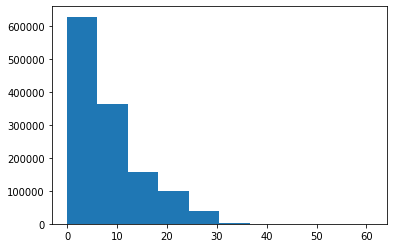

In [79]:
###Padding - checking for how to pad

list_len_Xt = [len(i) for i in X_train]
plt.hist(list_len_Xt)

In [18]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen=25)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', maxlen=25)

In [19]:
embedding_size = 10

def initialize_model():
    
    model = Sequential()
    
    model.add(layers.Embedding(input_dim=vocab_size+1,output_dim=embedding_size, mask_zero=True, input_length=25))
    
    model.add(layers.LSTM(20))
    
    model.add(layers.Dense(10, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                  metrics=['accuracy','Precision','Recall']
                 )
    return model

In [20]:
cnn = initialize_model()

cnn.summary()

2021-11-25 22:05:24.137165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-25 22:05:24.137210: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-25 22:05:24.137226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-K2LUF1RF): /proc/driver/nvidia/version does not exist
2021-11-25 22:05:24.137564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 10)            4711400   
_________________________________________________________________
lstm (LSTM)                  (None, 20)                2480      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 4,714,101
Trainable params: 4,714,101
Non-trainable params: 0
_________________________________________________________________


In [13]:
###Model architecture works, but it would take ages to complete. Will export files to colab and try to run the model there

es = EarlyStopping(patience=5, restore_best_weights=True)

history = cnn.fit(X_train_pad, y_train, 
          epochs=500, 
          batch_size=64,
          validation_split=0.3,
          callbacks=[es]
         )

2021-11-25 16:09:32.294103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
28228/28228 [==============================] - 468s 17ms/step - loss: 0.3254 - accuracy: 0.8880 - precision: 0.8104 - recall: 0.2218 - val_loss: 0.3047 - val_accuracy: 0.8970 - val_precision: 0.8632 - val_recall: 0.2777
Epoch 2/500
15502/28228 [===============>..............] - ETA: 3:15 - loss: 0.2689 - accuracy: 0.9084 - precision: 0.8537 - recall: 0.3875

KeyboardInterrupt: 

In [15]:
##writing df with clean text to parquet

parquet_df = get_final_tweet_data(en=True)
apply_text_cleaning(parquet_df, write_to_parquet=True)

ArrowNotImplementedError: Unhandled type for Arrow to Parquet schema conversion: duration[ns]

In [19]:
apply_text_cleaning(parquet_df, write_to_parquet=True)

,author_id,id,lang,text,created_at,lag,possibly_sensitive,referenced_tweets,reply_category,like_count,quote_count,reply_count,retweet_count,n_mentions,target,clean_text
13,1000197919,1261733558474829824,en,@trekonomics Same here. Best pate ever....have...,2020-05-16 19:01:36+00:00,33 days 14:13:11,False,True,Reply_to_other,0,0,0,0,1,human,best pate everhave searching taste since
14,1000197919,1264695397588406272,en,PCC is a great example....reach out to your el...,2020-05-24 23:10:54+00:00,8 days 04:09:18,False,True,No_reply,0,0,0,0,0,human,pcc great examplereach elected official
15,1000197919,1271119064941752320,en,both the theorem - and the conclusion. https:/...,2020-06-11 16:36:15+00:00,17 days 17:25:21,False,True,No_reply,0,0,0,0,0,human,theorem conclusion
16,1000197919,1273846820133695488,en,@GeneralCattis they're learning from the best!,2020-06-19 05:15:23+00:00,7 days 12:39:08,False,True,Reply_to_other,0,0,0,0,1,human,theyre learning best
17,1000197919,1275472007769976832,en,this thread... https://t.co/OSveBlPctt,2020-06-23 16:53:18+00:00,4 days 11:37:55,False,True,No_reply,0,0,0,0,0,human,thread
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2353366,999977095106367488,1426676881638793216,en,you ruined everything good\nalways said you we...,2021-08-14 22:47:29+00:00,0 days 13:31:13,False,False,No_reply,0,0,0,0,0,human,ruined everything goodalways said misunderstoo...
2353367,999977095106367488,1427777414088777728,en,for every question why \nyou were my because,2021-08-17 23:40:36+00:00,3 days 00:53:07,False,False,No_reply,0,0,0,0,0,human,every question
2353369,999977095106367488,1431950553173659648,en,song i wish someone wrote for me pt1: https://...,2021-08-29 12:03:10+00:00,8 days 15:31:58,False,False,No_reply,0,0,0,0,0,human,song wish someone wrote pt
2353371,999977095106367488,1435588625811611648,en,song i wish someone wrote for me pt2: https://...,2021-09-08 12:59:34+00:00,5 days 03:18:45,False,False,No_reply,0,0,0,0,0,human,song wish someone wrote pt


In [23]:
df[['clean_text', 'target']].to_parquet('../Twitter_bot_detection_713/data/clean_text.parquet')